### 비트코인 가격 예측

***참고**  
**처음으로 0에 수렴하는 시차 이후에 상관이 크게 줄어드는 지점이 적절한 차분 횟수이다.**  
**하지만 일반적인 기준점이므로 실제와 다를 수는 있기 때문에 여러 차분을 시도하여 결정해야 한다.**

In [1]:
import pandas as pd
import json

# json 형식의 파일을 load 하여 json_data에 객체 저장
with open('./datasets/bitcoin_2010_2024.json') as f:
    json_data = json.load(f)

# market-price라는 key 로 값이 등록되어 있기 떄문에 해당 value 값을 가져와서 데이터 프레임으로 저장
bitcoin_df = pd.DataFrame(json_data['market-price'])
bitcoin_df

,x,y
0,1230940800000,0.00
1,1231286400000,0.00
2,1231632000000,0.00
3,1231977600000,0.00
4,1232323200000,0.00
...,...,...
1405,1716508800000,67942.23
1406,1716854400000,69374.17
1407,1717200000000,67484.93
1408,1717545600000,70553.24


In [2]:
from datetime import datetime

# 현재 x 가 밀리초로 이루어져 있기 때문에 fromtimestamp를 이용하여 년,월,일 형식으로 변환하는 함수 생성
def changeDate(milis):
    timestamp = milis / 1000
    converted_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
    return converted_time

In [3]:
# apply를 사용하여 밀리초인 데이터를 년,월,일 문자열 형태로 변환
bitcoin_df.x = bitcoin_df.x.apply(changeDate)
bitcoin_df

,x,y
0,2009-01-03,0.00
1,2009-01-07,0.00
2,2009-01-11,0.00
3,2009-01-15,0.00
4,2009-01-19,0.00
...,...,...
1405,2024-05-24,67942.23
1406,2024-05-28,69374.17
1407,2024-06-01,67484.93
1408,2024-06-05,70553.24


In [4]:
# 시계열 데이터 이기 때문에 인덱스를 날짜로 변경
bitcoin_df.set_index('x', inplace=True)
bitcoin_df

,y
x,
2009-01-03,0.00
2009-01-07,0.00
2009-01-11,0.00
2009-01-15,0.00
2009-01-19,0.00
...,...
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93


In [5]:
# 시계열 데이터의 경우 인덱스의 형식이 datetime으로 되어있어야 하나
# 문자열 형태로 존재하기 때문에 단순 index로 표기되어 있는 것 확인
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1410 entries, 2009-01-03 to 2024-06-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1410 non-null   float64
dtypes: float64(1)
memory usage: 22.0+ KB


In [6]:
# 인덱스의 문자열을 날짜 형태로 바꿔즈는 to_datetime 사용
bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1410 entries, 2009-01-03 to 2024-06-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1410 non-null   float64
dtypes: float64(1)
memory usage: 22.0 KB


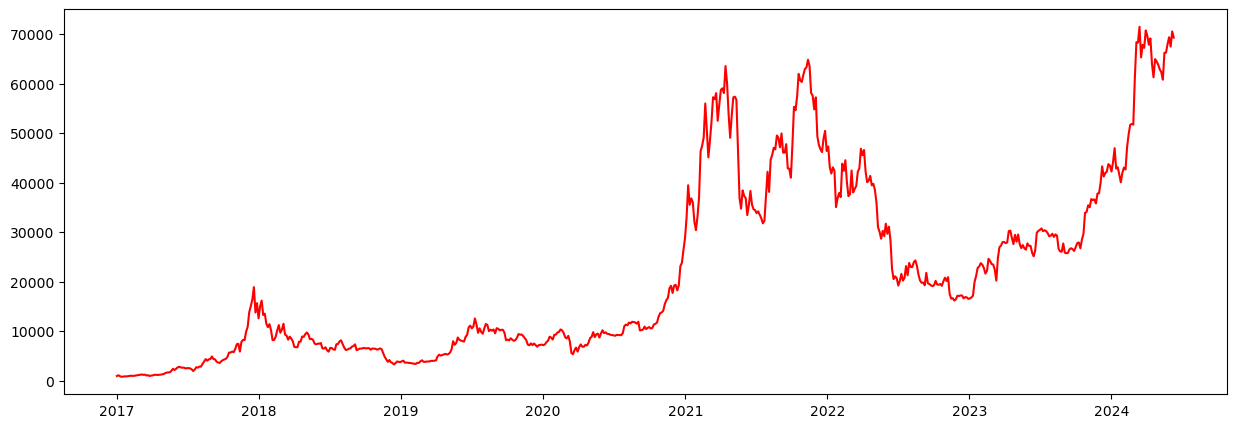

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# 시계열 데이터에 대하여 pyplot 을 통해 시각화
# 슬라이싱을 이용하여 2017-01-01 데이터만 출력

plt.plot(bitcoin_df['2017-01-01':], c='red')
plt.show()

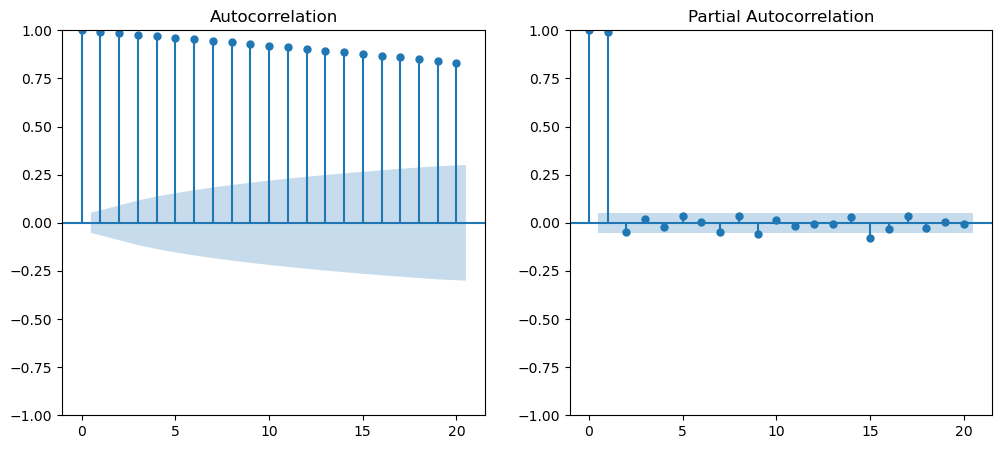

In [8]:
# 시계열 정상성 형태를 확인하기 위해 자기상관함수(acf), 부분자기상관함수(pacf) 임포트
# 시계열 데이터의 용도에 맞게 누적된 값에 대하여 차분이 필요하면 acf를 누적된 값이 아닌 부분에 대하여 차분이 필요하면 pacf를 사용할 것.
# AR에
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 그래프의 행,열 및 크기 조절
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 자기상관함수 사용
# 자기상관함수의 경우 누적된 값을 표기하고 있으며, 
# 정상성이 표기되지 않을 경우 추세: 천천히 감소할 경우, 계절: 물결 모양의 형태를 가지고 있기 때문에
# 정상성을 띄는 경우 0에 수렴한 그래프의 형태를 나타냅니다.
# 아래 자기상관함수의 경우 추세를 보이고 있기 때문에 천천히 감소하는 형태로 표기됩니다.
# lags는 계산할 때 고려할 최대 시차의 개수를 나타냅니다. 
fig = plot_acf(bitcoin_df, lags=20, ax=ax[0])

# 부분자기상관함수 사용
# 부분자기함수의 경우 누적된 값이 아닌 중간에 있는 시차들의 영향을 배제합니다.
# 다른 시차의 영향을 제거하고 해당 시차와의 상관관계만 측정합니다.
# 부분자기상관관계는 데이터의 직접적인 상관관계를 파악하는데 유용하지만 정상 시계열과 비정상 시계열을 구분하는데 어렵습니다.
# 따라서 아래 부분자기상관관계 함수의 경우 데이터의 직접적인 상관관계를 파악하는데 어렵지만 특정 시차와의 상관관계를 측정하는데 유용한 형태입니다.
fig = plot_pacf(bitcoin_df, lags=20, ax=ax[1])

# 위와 같은 그래프를 통해 데이터의 직접적인 상관관계를 확인할 수 있으며 차분의 값을 확인하여 n-1 의 차분의 값을 확인할 수 있다.

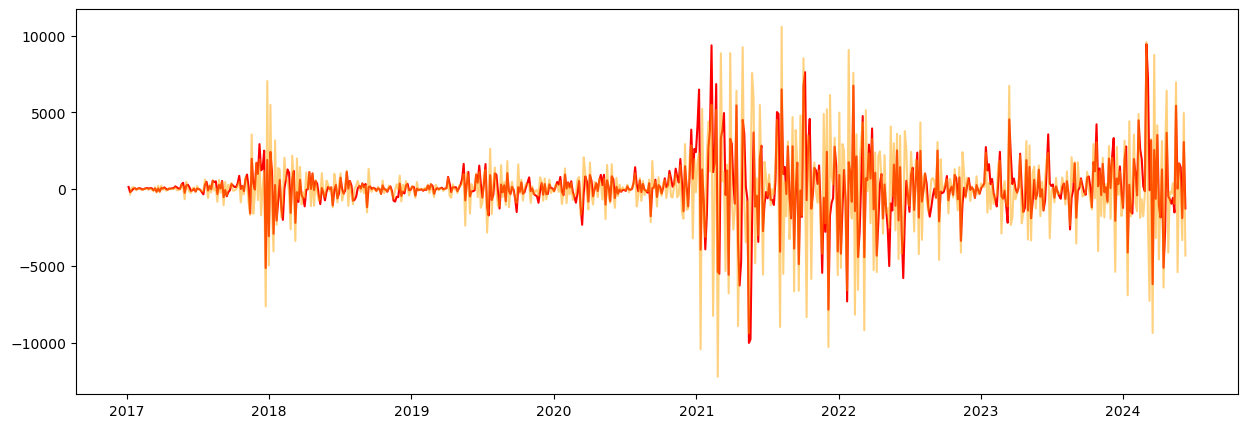

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# 1차 차분을 사용했을 때 데이터의 정상성을 확보할 수 있으며 필요시 추가적인 차분을 통해 정상성의 비율을 높일 수 있습니다.
plt.plot(bitcoin_df['2017-01-01':].diff().dropna(), c='red')

# diff().diff() 는 2차 차분을 진행함으로써 1차 차분을 진행했을 때보다 정상성의 분포가 더 튀는 것을 확인 할 수 있습니다. 
plt.plot(bitcoin_df['2017-01-01':].diff().diff().dropna(), c='orange', alpha=0.5)
plt.show()

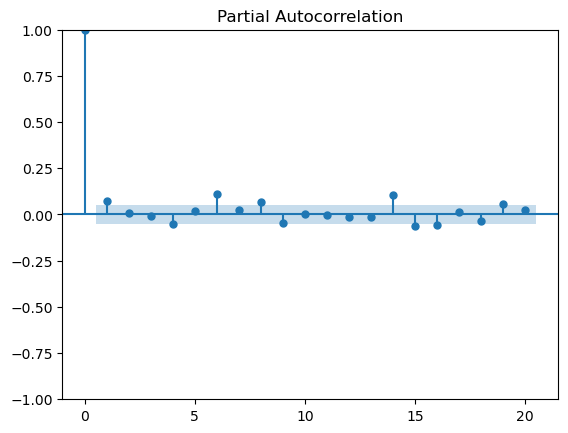

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 비트코인 데이터 프레임을 정상성있는 데이터 프레임으로 변경했기 때문에
# 부분자기상관함수를 사용하여 사분을 확인 (주식에 대한 데이터를 활용하기 때문에 서로 독립적인 데이터를 확인하는 \
# pacf를 사용)
plot_pacf(bitcoin_df.diff().dropna(), lags=20)
plt.show()

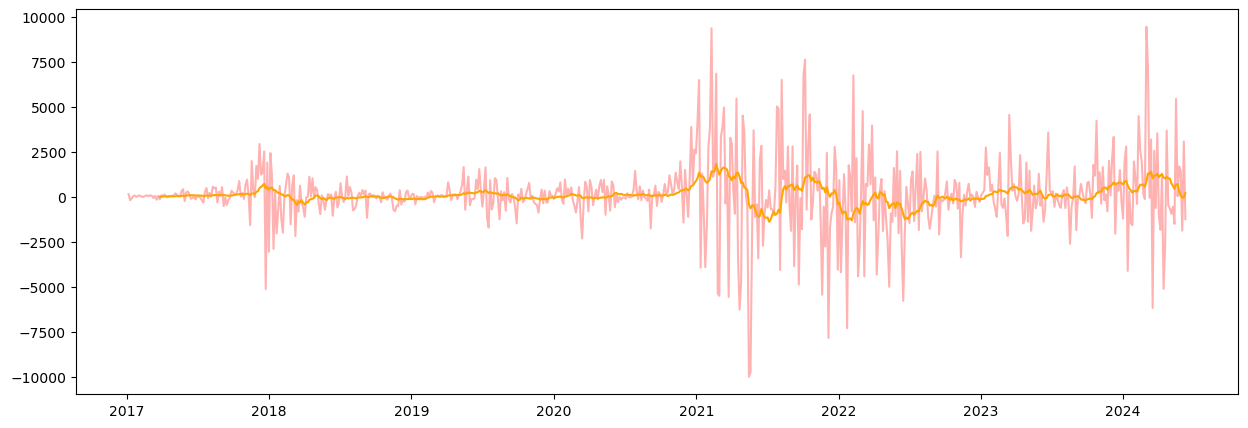

In [11]:
import matplotlib.pyplot as plt

# 평탄화 정도를 나타냄
window_size = 21

plt.figure(figsize=(15, 5))

# 정상성을 띄는 데이터프레임에 대하여 1차 차분을 진행하고 해당 데이터 프레임에 대하여 이동평균을 사용하여 시계열 데이터를 부드러운 패턴을 활용
# 이동평균을 사용하면 시계열 데이터의 추세를 이해하고 예측하는데 유용한 도구로 사용.
plt.plot(bitcoin_df['2017-01-01':].diff().dropna(), c='red', alpha=0.3)
plt.plot(bitcoin_df['2017-01-01':].diff().dropna().rolling(window_size).mean(), c='orange')
plt.show()

In [12]:
# 시각화 그래프의 편의성을 위해 특정 날짜 이후 데이터 프레임 변ㄴ경
bitcoin_df = bitcoin_df['2017-01-01':]
bitcoin_df

,y
x,
2017-01-01,964.84
2017-01-05,1109.16
2017-01-09,910.49
2017-01-13,805.52
2017-01-17,830.56
...,...
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93


In [13]:
# 2023년의 최초 인덱스를 확인하기 위한 내용
bitcoin_df['2023':]

,y
x,
2023-01-02,16613.71
2023-01-06,16826.41
2023-01-10,17192.07
2023-01-14,19933.36
2023-01-18,21145.18
...,...
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


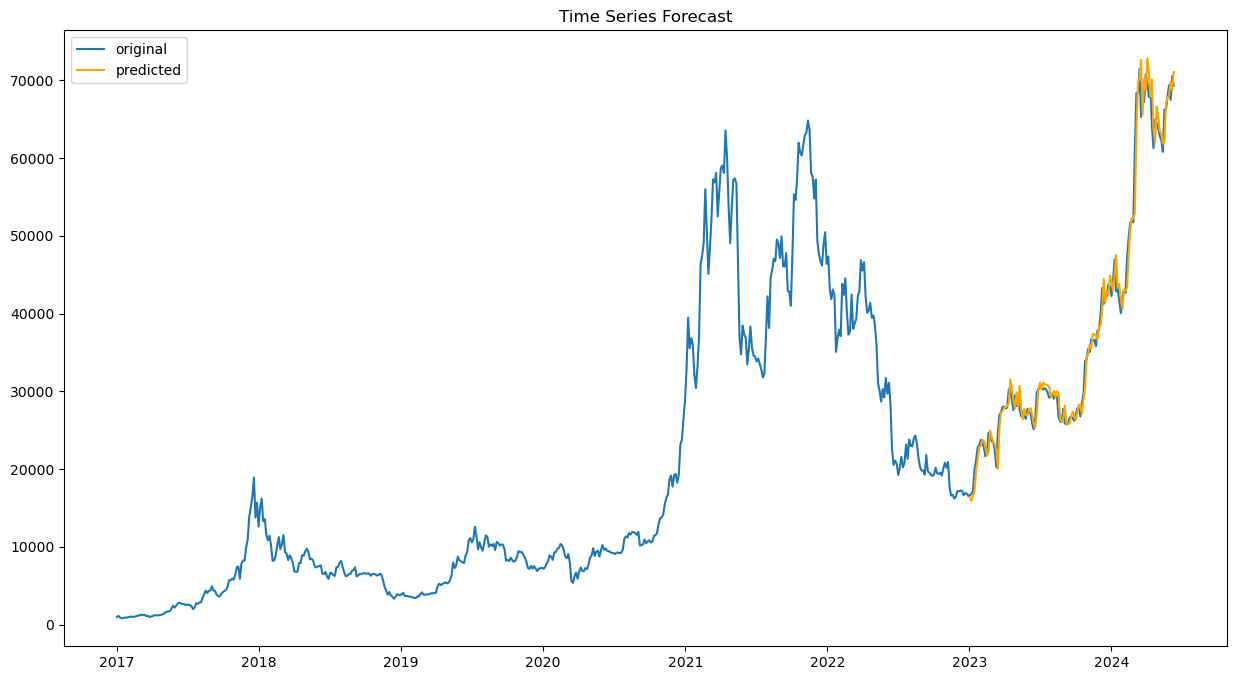

In [14]:
# 세상에는 안정시계열 데이터보다 불안정 시계열 데이터의 빈도가 높기 떄문에 차분을 활용할 수 있는 ARIMA 모델을 사용하도록 진행
from statsmodels.tsa.arima.model import ARIMA

# AR(n): 자기회귀 => n 은 차수를 의미하며 acf 또는 pacf를 통해 확인한 차수를 입력합니다.
# pacf의 차수는 0에 가까운 형태 이후에 가장 멀리 떨어져있는 차수 -1 를 사용해보면 좋지만 무조건 권장되는 것이 아니기 때문에
# 실제 그래프를 그려서 정상성을 어느정도 형태를 이루는 지 확인하는 것이 좋다.

# oredr = (ar차수, 차분 횟수, mr 정도)
model = ARIMA(bitcoin_df, order=(1, 4, 21))
model_fit = model.fit()

start_index = pd.to_datetime('2023-01-02')
end_index = pd.to_datetime('2024-06-09')

# 이 부분은 추가적인 예측이 아니라 기존 실제 데이터에서 모델 평가를 하는 부분
forecast = model_fit.predict(start=start_index, end=end_index)

plt.figure(figsize=(15, 8))
# 실제 시계열 데이터
plt.plot(bitcoin_df, label='original')
# model을 훈련시켜서 나온 결과에 대한 모델 검증
plt.plot(forecast, label='predicted', c='orange')
plt.title("Time Series Forecast")
plt.legend()
plt.show()

In [15]:
bitcoin_df.tail()

,y
x,
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93
2024-06-05,70553.24
2024-06-09,69297.93


In [16]:
forecast.tail()

2024-05-24    67747.907430
2024-05-28    68106.860000
2024-06-01    69825.512224
2024-06-05    68774.347522
2024-06-09    71075.615363
Freq: 4D, Name: predicted_mean, dtype: float64

In [17]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# 1, 1, 21
# Mean Squared Error 3675472.7344317045
# Mean Squared Error 0.0024020982419680537

# 4, 1, 21
# Mean Squared Error 3834201.646153027
# Mean Squared Error 0.002482140891774656

# 1, 4, 21
# Mean Squared Error 3940089.8362798565
# Mean Squared Error 0.0025307012448420804

mse = mean_squared_error(bitcoin_df['2023-01-02':'2024-06-09'], forecast)
print("Mean Squared Error", mse)

mse = mean_squared_error(bitcoin_df['2023-01-02':'2024-06-09'], forecast)
print("Root Mean Squared Error", mse ** (1/2))

msle = mean_squared_log_error(bitcoin_df['2023-01-02':'2024-06-09'], forecast)
print("Mean Squared Log Error", msle)

Mean Squared Error 3902793.0588772893
Root Mean Squared Error 1975.5487994168327
Mean Squared Log Error 0.002558138470515048
